In [16]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random


import torch.nn.init
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

torch.manual_seed(777)   #random value를 잡아주는? 항상 같은 random이 나오는 걸로 설명은 되어있으나 완벽하게 이해 못함 질문1
if device == 'cuda' : 
    torch.cuda.manual_seed_all(777)

In [18]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# data 다운 되게 만드는 보안 헤더 코드???? 질문2

In [19]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [20]:
#parameters 정의해둠 > data loader에 써야되니까 batch size등
learning_rate = 0.001
training_epochs =15
batch_size = 100

In [21]:
data_loader = torch.utils.data.DataLoader(dataset =mnist_train,
                                         batch_size = batch_size,
                                          shuffle = True,
                                          drop_last = True)

In [22]:
class CNN(nn.Module) :
    
    def __init__(self) :
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # fully connected layer
        self.fc = nn.Linear(7*7*64,10,bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight) #초기화진행
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [23]:
model = CNN().to(device)

In [24]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [25]:
#training
total_batch = len(data_loader)
list_epoch = []
list_train_loss = []
list_train_accuracy = []

for epoch in range(training_epochs) :
    avg_cost = 0
    
    for X, Y in data_loader :
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        avg_cost += cost/total_batch 
        
    list_epoch.append(epoch)
    list_train_loss.append(cost/total_batch)
              
    print('[Epoch:{}] cost = {}'.format(epoch+1, avg_cost))
    
    with torch.no_grad():    #학습안할꺼니까 선언
        X_test = mnist_test.test_data.view(len(mnist_test),1,28,28).float().to(device)
        Y_test = mnist_test.test_labels.to(device)
    
        prediction = model(X_test)
        correct_prediction = torch.argmax(prediction, 1) == Y_test
        accuracy = correct_prediction.float().mean()
        
    list_train_accuracy.append(accuracy.item())
    
    print('Accuracy : ',accuracy.item())
    
print('Finished')

[Epoch:1] cost = 0.22393102943897247
Accuracy :  0.9591999650001526
[Epoch:2] cost = 0.06218036636710167
Accuracy :  0.9750999808311462
[Epoch:3] cost = 0.04491035267710686
Accuracy :  0.976699948310852
[Epoch:4] cost = 0.035423073917627335
Accuracy :  0.9830999970436096
[Epoch:5] cost = 0.02900533936917782
Accuracy :  0.9853999614715576
[Epoch:6] cost = 0.024785390123724937
Accuracy :  0.9805999994277954
[Epoch:7] cost = 0.020776621997356415
Accuracy :  0.977899968624115
[Epoch:8] cost = 0.018033316358923912
Accuracy :  0.9866999983787537
[Epoch:9] cost = 0.015019230544567108
Accuracy :  0.9817999601364136
[Epoch:10] cost = 0.012545665726065636
Accuracy :  0.9871999621391296
[Epoch:11] cost = 0.010405885055661201
Accuracy :  0.9866999983787537
[Epoch:12] cost = 0.009895054623484612
Accuracy :  0.9840999841690063
[Epoch:13] cost = 0.00852569006383419
Accuracy :  0.9842000007629395
[Epoch:14] cost = 0.006999878212809563
Accuracy :  0.9842999577522278
[Epoch:15] cost = 0.0063141309656202

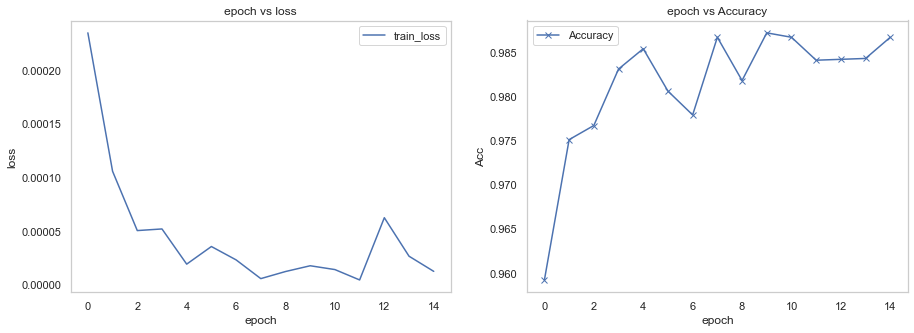

In [26]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_train_accuracy, marker='x', label='Accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()